In [1]:
import sys
sys.path.append('/mnt/apollo/bare_soil_xuemeng/scikit-map/')

from skmap.io import RasterData
from skmap.io import process
import os

from pathlib import Path
from minio import Minio
from eumap.misc import find_files, nan_percentile, ttprint
from eumap.raster import read_rasters, save_rasters
import numpy as np
from minio.commonconfig import REPLACE, CopySource
import time as tm
import multiprocess as mp

tiles = ['006E_51N', '023E_52N', '007E_46N'] #, , '004W_36N', '004E_51N',  '024E_38N'
# tiles = ['016E_63N','017E_63N','006W_53N','006W_52N','003E_52N','004E_52N','003E_51N','004E_51N','005E_52N','006E_52N','005E_51N',
#          '006E_51N','023E_52N','007E_46N','008E_46N','009E_44N','010E_44N','023E_38N','024E_38N','023E_37N','004W_36N']
years = list(range(2000,2022,1))
doy = ['001','017','033','049','065','081','097','113','129','145','161','177','193','209','225','241','257','273','289','305','321','337','353']
bands = ['blue','green','red','NIR','SWIR1','SWIR2']
# bands = [('blue',1),('green',2),('red',3),('NIR',4),('SWIR1',5),('SWIR2',6),('thermal',7),('qa',8)]

In [2]:
def index_calc(tile,year):
    tile = tile.replace('_','.')
    prefix_local = f'/mnt/apollo/bare_soil_xuemeng/tmp_files'
    prefix_url = 'http://192.168.1.30:8333/tmp-bare-soil/16days'
    
    # print(fbands)
    # if os.path.exists(f'/mnt/tupi/Xuemeng_testing/bsi/{period}/bsi_{tss}_{ys}335.tif'):
    #     print(f'{ts}, {ys} , {period} done!')
    #     return None
    
    # fbands = [prefix_local + f'/gapfilled/{tile}/landsat_gapfilled_{band}_{tile}_'+'{dt}.tif' for band in bands]
    # group = dict(zip(bands, fbands))
    # rdata = RasterData(group, verbose=True) \
    # .timespan(f'{str(year)}001', f'{str(year)}354', date_step=16, date_unit='days', date_format='%Y%j', date_style='start_date', ignore_29feb=True) \
    # .read(n_jobs=40)
    
    all_data = []
    for band in bands:
        files = [prefix_local+f'/gapfilled/{tile}/landsat_gapfilled_{band}_{tile}_{year}{dt}.tif' for dt in doy]
        files = [Path(i) for i in files]
        data,_ = read_rasters(raster_files=files, n_jobs = 30, verbose=True)
        all_data.append(data)
    rdata = np.concatenate(all_data, axis=2)
    ttprint(f'finish reading, start calculating: {rdata.shape}')
    

    with np.errstate(divide='ignore', invalid='ignore'):
            ndvi = np.divide((rdata[:, :, 69:92] - rdata[:, :, 46:69]),
                             (rdata[:, :, 69:92] + rdata[:, :, 46:69]))
    ndvi[np.isinf(ndvi) | np.isnan(ndvi)] = np.nan
        
    with np.errstate(divide='ignore', invalid='ignore'):
        bsi = np.divide((rdata[:, :, 92:115] + rdata[:, :, 46:69] - rdata[:, :, 0:23] - rdata[:, :, 69:92]),
                        (rdata[:, :, 92:115] + rdata[:, :, 46:69] + rdata[:, :, 0:23] + rdata[:, :, 69:92]))
    bsi[np.isinf(bsi) | np.isnan(bsi)] = np.nan
        
    with np.errstate(divide='ignore', invalid='ignore'):
        ndti = np.divide((rdata[:, :, 92:115] - rdata[:, :, 115:138]),
                         (rdata[:, :, 92:115] + rdata[:, :, 115:138]))
    ndti[np.isinf(ndti) | np.isnan(ndti)] = np.nan
    
    ttprint(f'writing out {ndti.shape}')
    outfiles = [prefix_local+f'/ndvi/{tile}/ndvi_{tile}_{year}{dd}.tif' for dd in doy]
    save_rasters(files[0], outfiles, ndvi*10000, dtype = 'int16', n_jobs=30)
    outfiles = [i.replace('ndvi','bsi') for i in outfiles]
    save_rasters(files[0], outfiles, bsi*10000, dtype = 'int16', n_jobs=30)
    outfiles = [i.replace('bsi','ndti') for i in outfiles]
    save_rasters(files[0], outfiles, ndti*10000, dtype = 'int16', n_jobs=30)
    ttprint(f'{tile}, {year} finished')
    return None

In [3]:
for tile in tiles:
    for year in years:
        index_calc(tile,year)

[12:25:50] Reading 23 raster files using 30 workers
[12:25:56] Reading 23 raster files using 30 workers
[12:26:00] Reading 23 raster files using 30 workers
[12:26:04] Reading 23 raster files using 30 workers
[12:26:08] Reading 23 raster files using 30 workers
[12:26:12] Reading 23 raster files using 30 workers
[12:26:20] finish reading, start calculating: (4004, 4004, 138)


/tmp/ipykernel_82956/864207880.py:29: RuntimeWarning: overflow encountered in add
  (rdata[:, :, 69:92] + rdata[:, :, 46:69]))
/tmp/ipykernel_82956/864207880.py:34: RuntimeWarning: overflow encountered in add
  (rdata[:, :, 92:115] + rdata[:, :, 46:69] + rdata[:, :, 0:23] + rdata[:, :, 69:92]))
/tmp/ipykernel_82956/864207880.py:39: RuntimeWarning: overflow encountered in add
  (rdata[:, :, 92:115] + rdata[:, :, 115:138]))


[12:27:09] writing out (4004, 4004, 23)
[12:27:29] 006E.51N, 2000 finished
[12:27:29] Reading 23 raster files using 30 workers
[12:27:34] Reading 23 raster files using 30 workers
[12:27:38] Reading 23 raster files using 30 workers
[12:27:43] Reading 23 raster files using 30 workers
[12:27:48] Reading 23 raster files using 30 workers
[12:27:52] Reading 23 raster files using 30 workers
[12:28:01] finish reading, start calculating: (4004, 4004, 138)
[12:28:51] writing out (4004, 4004, 23)
[12:29:14] 006E.51N, 2001 finished
[12:29:14] Reading 23 raster files using 30 workers
[12:29:18] Reading 23 raster files using 30 workers
[12:29:22] Reading 23 raster files using 30 workers
[12:29:26] Reading 23 raster files using 30 workers
[12:29:31] Reading 23 raster files using 30 workers
[12:29:35] Reading 23 raster files using 30 workers
[12:29:43] finish reading, start calculating: (4004, 4004, 138)
[12:30:33] writing out (4004, 4004, 23)
[12:30:53] 006E.51N, 2002 finished
[12:30:53] Reading 23 r

/tmp/ipykernel_82956/864207880.py:33: RuntimeWarning: overflow encountered in add
  bsi = np.divide((rdata[:, :, 92:115] + rdata[:, :, 46:69] - rdata[:, :, 0:23] - rdata[:, :, 69:92]),


[12:32:12] writing out (4004, 4004, 23)
[12:32:31] 006E.51N, 2003 finished
[12:32:31] Reading 23 raster files using 30 workers
[12:32:35] Reading 23 raster files using 30 workers
[12:32:39] Reading 23 raster files using 30 workers
[12:32:43] Reading 23 raster files using 30 workers
[12:32:48] Reading 23 raster files using 30 workers
[12:32:52] Reading 23 raster files using 30 workers
[12:33:00] finish reading, start calculating: (4004, 4004, 138)
[12:33:49] writing out (4004, 4004, 23)
[12:34:08] 006E.51N, 2004 finished
[12:34:08] Reading 23 raster files using 30 workers
[12:34:13] Reading 23 raster files using 30 workers
[12:34:17] Reading 23 raster files using 30 workers
[12:34:22] Reading 23 raster files using 30 workers
[12:34:26] Reading 23 raster files using 30 workers
[12:34:31] Reading 23 raster files using 30 workers
[12:34:40] finish reading, start calculating: (4004, 4004, 138)
[12:35:30] writing out (4004, 4004, 23)
[12:35:51] 006E.51N, 2005 finished
[12:35:51] Reading 23 r

ERROR 1: TIFFFillStrip:Read error at scanline 1547; got 5090 bytes, expected 8727
ERROR 1: TIFFReadEncodedStrip() failed.
ERROR 1: /mnt/apollo/bare_soil_xuemeng/tmp_files/gapfilled/007E.46N/landsat_gapfilled_SWIR2_007E.46N_2012353.tif, band 1: IReadBlock failed at X offset 0, Y offset 1548: TIFFReadEncodedStrip() failed.


Exception: The raster /mnt/apollo/bare_soil_xuemeng/tmp_files/gapfilled/007E.46N/landsat_gapfilled_SWIR2_007E.46N_2012049.tif was not found.

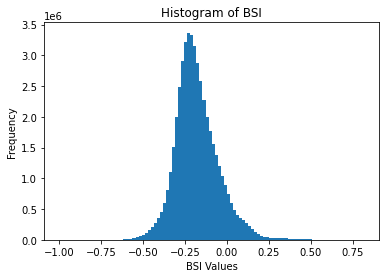

In [23]:
# # check data quality
# nfiles = find_files('/mnt/tupi/Xuemeng_testing/bsi/monthly/','bsi*.tif')
# print(len(nfiles)-12*22*5)
# print(len(files))

# bsi = a[0].flatten()
# import matplotlib.pyplot as plt
# plt.hist(bsi, bins=100)  # 'bins' parameter sets the number of bins in the histogram
# plt.xlabel('BSI Values')    # Set the X-axis label (optional)
# plt.ylabel('Frequency')     # Set the Y-axis label (optional)
# plt.title('Histogram of BSI')  # Set the title of the histogram (optional)
# plt.show() 